In [ ]:
!pip install openai

import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
from openai import OpenAI
from google.colab import userdata
import os

Mounted at /content/gdrive


In [ ]:
# Set the API key from Colab's user data secrets
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

client = OpenAI()

client.batches.create(
  input_file_id="file-abc123",
  endpoint="/v1/chat/completions",
  completion_window="24h"
)

Batch(id='batch_687fb091873c81908e7564086d37261b', completion_window='24h', created_at=1753198737, endpoint='/v1/chat/completions', input_file_id='file-abc123', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1753285137, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

## **undersampled** **data**

In [ ]:
# this data is UNDERSAMPLED

new = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/cleaned_banktrack_annotated.csv')
# Use Coral's balanced dataset
from datasets import Dataset, DatasetDict

# Convert pandas DataFrame to Hugging Face DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(new)
})

def undersample_majority_class(dataset_dict, label_column):
    # Extract train split
    np.random.seed(42)
    train_data = dataset_dict["train"]
    labels = np.array(train_data[label_column])
    # Identify majority and minority classes
    class_counts = np.bincount(labels)
    minority_class = np.argmin(class_counts)
    minority_count = np.min(class_counts)
    # Get indices for both classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels != minority_class)[0]
    # Randomly select subset of majority class to match minority count
    undersampled_majority_indices = np.random.choice(
        majority_indices,
        size=minority_count,  # Match minority count
        replace=False  # No duplicates
    )
    # Combine selected majority + all minority samples
    new_indices = np.concatenate([undersampled_majority_indices, minority_indices])
    # Create new balanced dataset
    balanced_train = train_data.select(new_indices)
    return DatasetDict({
        "train": balanced_train,
        # "validation": dataset_dict["validation"]  # Validation remains unchanged
    })
# Usage
dataset = undersample_majority_class(
    dataset,
    label_column="contains_debt_instrument_information"
)

# Verify
print("Original counts:", np.bincount(dataset["train"]["contains_debt_instrument_information"]))
print("Balanced counts:", np.bincount(dataset["train"]["contains_debt_instrument_information"]))
new_undersampled = dataset["train"].to_pandas()

Original counts: [55 55]
Balanced counts: [55 55]


In [ ]:
#split dataset to training and validation
split_dataset = dataset["train"].train_test_split(
    test_size=0.2,      # 20% for validation
    seed=42,            # For reproducibility
    shuffle=True        # Shuffle before splitting
)

# Create the final DatasetDict with both splits
dataset = DatasetDict({
    "train": split_dataset["train"],          # 80% (133 rows)
    "validation": split_dataset["test"]       # 20% (33 rows)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'company', 'cik', 'item', 'contains_debt_instrument_information'],
        num_rows: 140
    })
    validation: Dataset({
        features: ['index', 'text', 'company', 'cik', 'item', 'contains_debt_instrument_information'],
        num_rows: 36
    })
})

In [ ]:
import openai
def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """A Form 8-K is a public document that publicly traded companies must file with the Securities and Exchange Commission (SEC) to disclose significant, unscheduled events or corporate changes. These events are considered material, meaning they could impact the company's financial performance or investor decisions.
        Debt financing is when a company borrows money (or is given the right to borrow money) from a collection of lenders. This is primarily done through bonds, notes, loans, credit facilities. Key words include: Term Loan Agreement, Amended and Restated Credit Agreement, Revolving Credit Agreement, Junior Subordinated Notes, Bond, Debt Settlement Agreement.
        Classification is 'True' if the item contains details about a debt instrument. If the item just references a debt instrument, this column should still be false. There must be some details outside of the name (such as the start date, the amount, the lenders, etc.).
        I want you to think like a financial analyst reviewing SEC Form 8-K filings to determine whether they contain information related to commercial debt. Your response should classify each text with a “True” or “False” label. Do not explain.


Examples:
1. "    Alpha Holding Company, LLC Disposition  On January 19, 2017, Concho Resources Inc. (the  Company ), through its wholly owned subsidiary, COG Operating LLC  ( Seller ), entered into a definitive securities purchase agreement (the  Purchase Agreement ) with Plains Pipeline, L.P. ( Purchaser ) to sell 100% of the issued and  outstanding Class A Units of Alpha Holding Company, LLC ( AHC ) (the  Disposition ), for aggregate consideration of approximately $800 million, subject to customary purchase price  adjustments, after closing of the transactions contemplated by the Class B Purchase Agreement (defined below) and repayment of the outstanding borrowings under the credit facility of Alpha Crude Connector, LLC, a wholly owned subsidiary of AHC.  Contemporaneously with the execution of the Purchase Agreement, Purchaser entered into a definitive purchase agreement with Frontier Midstream Solutions, LLC ( Frontier ) to purchase 100% of the issued and outstanding  Class B Units of AHC (the  Class  B Purchase Agreement ). Closing under the Purchase Agreement and the Class B Purchase Agreement is anticipated to occur contemporaneously during the  first half of 2017, subject to customary closing conditions, as further described below. Seller retains the right under the Limited Liability Company Agreement of AHC, subject to certain conditions, to purchase or cause AHC to purchase all of the  Class B Units of AHC prior to closing under the Purchase Agreement and the Class B Purchase Agreement (an  Option Exercise ). In the event of an Option Exercise, Seller will sell all of the Class A Units and  the Class B Units of AHC to Purchaser for an aggregate purchase price of approximately $1.215 billion. The Company expects the net proceeds to Seller in the event of an Option Exercise and sale to Purchaser of all of the Class A Units and  the Class B Units of AHC to be substantially similar to what Seller would otherwise receive under the Purchase Agreement in the absence of an Option Exercise.  Each partys obligation to consummate the Disposition is conditioned upon, among other things, (i) confirmation of the  counterparties representations and warranties as of the closing, (ii) the counterparties performance, in all material respects, of all covenants, (iii) the receipt of all required approvals (including approval under the  Hart-Scott-Rodino Antitrust Improvements Act of 1976), (iv) the absence of legal matters prohibiting the Disposition, and (v) the satisfaction or waiver by Frontier or Purchaser, as applicable, of certain conditions precedent to the  consummation of the transactions contemplated by the Class B Purchase Agreement.  " → False
2. "    As previously disclosed, between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Initial Notes ") to a total of eight lenders, and on December 30, 2022, the Company issued a secured promissory note in the principal amount of $2.0 million (the " First   C5 Note ") to an entity affiliated with C5 Capital Limited (" C5 "), a beneficial owner of more than 5% of the Company's outstanding common stock.    In connection with the issuance of the First C5 Note, the Company and the holders of the Initial Notes agreed to amend and restate the Initial Notes to be substantially in the form to be issued to C5, which form was attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023 (the " Restated Initial Notes "). This amendment and restatement occurred on January 11, 2023. The Restated Initial Notes continue to bear interest at a rate of 13.8% per annum from the respective dates of the Initial Notes, and the Restated Initial Notes are payable at scheduled maturity on June 30, 2023.    Upon entering into the First C5 Note, the Company and C5 also agreed to amend and restate the First C5 Note. Subsequently, the parties agreed that the amended and restated First C5 Note and any future notes to be issued in connection with additional bridge financing by C5 would be convertible into shares of the Company's common stock. On January 11, 2023, the Company issued to C5 an amended and restated convertible promissory note in the principal amount of $2.0 million (the " Restated C5 Note "). On January 12, 2023, the Company issued to C5 a new secured convertible promissory note in the principal amount of $3.0 million (the " Second C5 Note "). The Restated C5 Note and the Second C5 Note (collectively, the " C5 Notes "), in the aggregate principal amount of $5.0 million, are in substantially the form of secured convertible promissory note attached to this report as Exhibit 99.1.    The C5 Notes bear interest at a rate of 13.8% per annum from the date of issuance (or in the case of the Restated C5 Note, from the date of the First C5 Note), and all such notes are payable at scheduled maturity on June 30, 2023, subject to acceleration in certain circumstances.    The Company's obligations under the Restated Initial Notes and the C5 Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. C5 and each of the holders of the Restated Initial Notes have executed an Amended and Restated Security Agreement in the form attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023.    The C5 Notes provide C5 with the right, at any time on or after the date that is five calendar days prior to maturity, to convert any portion of the principal amount of the C5 Notes, together with any accrued and unpaid interest and any other unpaid amounts, into shares of the Company's common stock, par value $0.0001 per share (the " Common Stock "), at a conversion price of $2.00 per share. In the event that any shares of Common Stock are issued upon conversion of the C5 Notes, the Company has agreed to grant specified registration rights to C5.    The foregoing description of the C5 Notes does not purport to be complete and is subject to, and is qualified in its entirety by reference to, the form of C5 Note filed herewith as Exhibit 99.1 and incorporated herein by reference.  " → True
3. "    Between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Notes ") to a total of eight lenders. The lenders included GEN Keith B. Alexander (Ret.), the founder, Chief Executive Officer and Chairman of the Board of Directors of the Company. The Notes were also issued to lenders that include VADM John M. McConnell (Ret.), Hon. Michael J. Rogers, Theodore E. Schlein and VADM Jan E. Tighe (Ret.), each of whom is a director of the Company, as well as funds affiliated with Forgepoint Capital (the " Forgepoint Funds "). Donald R. Dixon, a member of the Company's board of directors, is an affiliate of ForgePoint Capital, and the ForgePoint Funds are also beneficial owners of greater than 5% of the Company's common stock.    Each Note has a scheduled maturity date of one year from the date of issuance, except that the Note issued to one lender that is not, and is not affiliated with, a director of the Company has a scheduled maturity date of six months from the date of issuance. The Notes bear interest at a rate of 13.8% per annum, payable at maturity. The Company may prepay the Notes at any time without premium or penalty, and the Notes do not restrict the incurrence of future indebtedness by the Company.    In the event that the Company fails to timely pay amounts due under the Notes or the Company materially defaults in its performance of any other covenant under the Notes or the Security Agreement (as defined below), which default is not cured within 30 days after written notice thereof, then at the option of the lenders, upon the written consent of lenders representing a majority of the outstanding and unpaid principal under the Notes, all unpaid principal, accrued interest and other amounts owing under the Notes shall be immediately due and payable.    In the event that the Company files any petition or action for relief under any bankruptcy, reorganization, insolvency or moratorium law or any other law for the relief of or relating to debtors, or makes any assignment for the benefit of creditors or takes any corporate action in furtherance thereof, or if an involuntary petition is filed against the Company (unless such petition is dismissed or discharged within 60 days) under any bankruptcy statute, or a custodian, receiver, trustee, assignee for the benefit of creditors is appointed to take possession, custody or control of any property of the Company, then all unpaid principal, accrued interest and other amounts owing under the Notes will accelerate and automatically become immediately due and payable.    The Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. The Company entered into a Security Agreement (the " Security Agreements ") with each of the lenders.    The forgoing descriptions of the Notes and the Security Agreements do not purport to be complete and are subject to, and are qualified in their entirety by reference to, the form of Note and form of Security Agreement filed hereto as Exhibits 4.1 and 10.1, respectively, and incorporated herein by reference.  " → True
4. "    Credit Agreement  In connection with the completion of the Merger, on August 4, 2016, Higher One, Inc. ( Higher One ), a Delaware corporation and direct  wholly owned subsidiary of the Company, terminated the existing credit agreement, dated as of October 16, 2012 (as amended, the  Credit Agreement ), among Higher One, as borrower, the Company, Higher One Machines, Inc.,  Higher One Real Estate, Inc. and Higher One Real Estate SP, LLC, as guarantors, Bank of America, N.A. as administrative agent, swingline lender and letter of credit issuer, and the other lenders party thereto, and all commitments thereunder. At the  time of such termination, there were no outstanding revolving loans or outstanding letters of credit under the Credit Agreement. In connection with such termination, all liens on the assets of Higher One, the Company and Higher Ones  subsidiaries securing such facility, together with such subsidiary or Company guarantees, were released and terminated." → True

Now classify the following:
   """
# building a numbered list of sentences to append to prompt so model can process a batch of inputs at once
# with clear numbering and formatting for each input example
    numbered_batch = ""
    for i, sentence in enumerate(batch_texts, start=start_idx):
        numbered_batch += f"{i}. \"{sentence}\" →\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create( # maybe use different function rather than chat completion
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

results = []
batch_size = 15 # Process 5 rows at a time

In [ ]:
# converting the text data into a list, looping through it in batches, classifying each batch,
# printing the output, and collecting all classification results in one list
texts = new_undersampled['text'].astype(str).tolist()

results = [] # Initialize the results list before the loop

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    output = classify_batch(batch, start_idx=i+1)
    #print(f"Batch {i//batch_size + 1} output:")
    print(output)
    # Extract just the True/False from each line of the output
    batch_results = [r.split('. ')[1] for r in output.strip().split('\n')]
    results.extend(batch_results)

print(f"Total results collected: {len(results)}")

In [ ]:
print(new_undersampled.columns)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_undersampled['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

In [ ]:
from sklearn.metrics import f1_score,classification_report

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_undersampled['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)



f1 = f1_score(true, preds)
print(f"F1 Score: {f1:.3f}")

# (Optional) See full breakdown: precision, recall, etc.
print("\nClassification Report:")
print(classification_report(true, preds))



In [ ]:
import openai
def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """You are a financial document classifier. Your task is to determine whether a given filing text contains **commercial debt-related information**. Respond with: \"True\" if the text includes any mention of **debt issuance, credit facilities, loans, promissory notes, or other financing agreements** (e.g., secured/unsecured notes, debt restructuring, bridge financing, convertible debt, etc.) and \"False\" if the text **does not** discuss any such debt-related topics. Be on the lookout for financial terms and phrases such as: \"credit agreement,\" \"debt,\" \"principal amount,\" \"secured note,\" \"loan facility,\" \"bridge financing,\" \"convertible promissory note,\" \"interest rate,\" \"maturity,\" \"collateral,\" \"security agreement,\" etc.


Examples:
"Text: Concho Resources agreed to sell Alpha Holding Company for ~$800M, contingent on the sale of Class B units and repayment of Alpha Crude Connector’s credit facility. A clause allows purchase of Class B units prior to sale, increasing total price to ~$1.215B. Conditions include regulatory and legal approvals."
"Classification: False"

"Text: IronNet issued secured promissory notes totaling $6.9M and $2.0M in December 2022, later amended and restated into convertible notes. Further $3.0M in secured convertible notes were issued in January 2023. All notes bear 13.8% interest, are secured (excluding IP), and are convertible into common stock."
"Classification: True"

"Text: IronNet issued $6.9M in secured promissory notes to board members and investors. Notes mature in 6–12 months with 13.8% interest. They are secured by company assets (excluding IP) and subject to acceleration upon default or bankruptcy."
"Classification: True"

"Text: Higher One, a subsidiary of the Company, terminated its credit agreement with Bank of America upon completion of a merger. There were no outstanding loans or credit lines at termination. All related liens and guarantees were released."
"Classification: True"

"Text: Company and C5 agreed to an exclusivity period for a potential acquisition, contingent on C5 providing bridge financing of $2M, with extensions tied to additional financing up to $3.5M."
"Classification: False"

"Text: Fuse Enterprises agreed to a private placement sale of ~19.6M shares for ~$6.87M to Landbond Home Limited."
"Classification: False"

"Text: Registrant filed exhibits related to the public issuance of various asset-backed notes by CNH Equipment Trust, as described in official prospectus documents."
"Classification: False"

Now classify the following:
   """
# building a numbered list of sentences to append to prompt so model can process a batch of inputs at once
# with clear numbering and formatting for each input example
    numbered_batch = ""
    for i, sentence in enumerate(batch_texts, start=start_idx):
        numbered_batch += f"{i}. \"{sentence}\" →\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create( # maybe use different function rather than chat completion
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

results = []
batch_size = 5 #Process 5 rows at a time


**This is also undersampled but dif prompt**

In [ ]:
import openai

def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """You are a financial document classifier. Your task is to determine whether a given filing text contains **commercial debt-related information**. Respond with: \"True\" if the text includes any mention of **debt issuance, credit facilities, loans, promissory notes, or other financing agreements** (e.g., secured/unsecured notes, debt restructuring, bridge financing, convertible debt, etc.) and \"False\" if the text **does not** discuss any such debt-related topics. Be on the lookout for financial terms and phrases such as: \"credit agreement,\" \"debt,\" \"principal amount,\" \"secured note,\" \"loan facility,\" \"bridge financing,\" \"convertible promissory note,\" \"interest rate,\" \"maturity,\" \"collateral,\" \"security agreement,\" etc.

Examples:
"Text: Concho Resources agreed to sell Alpha Holding Company for ~$800M, contingent on the sale of Class B units and repayment of Alpha Crude Connector's credit facility. A clause allows purchase of Class B units prior to sale, increasing total price to ~$1.215B. Conditions include regulatory and legal approvals."
"Classification: False"

"Text: IronNet issued secured promissory notes totaling $6.9M and $2.0M in December 2022, later amended and restated into convertible notes. Further $3.0M in secured convertible notes were issued in January 2023. All notes bear 13.8% interest, are secured (excluding IP), and are convertible into common stock."
"Classification: True"

"Text: IronNet issued $6.9M in secured promissory notes to board members and investors. Notes mature in 6–12 months with 13.8% interest. They are secured by company assets (excluding IP) and subject to acceleration upon default or bankruptcy."
"Classification: True"

"Text: Company and C5 agreed to an exclusivity period for a potential acquisition, contingent on C5 providing bridge financing of $2M, with extensions tied to additional financing up to $3.5M."
"Classification: False"


Now classify each text with just 'True' or 'False':

"""

    # Simpler formatting without complex numbering
    numbered_batch = ""
    for sentence in batch_texts:
        numbered_batch += f"Text: \"{sentence}\"\nClassification: \n\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

# Main processing code
results = []
batch_size = 1  # Process 5 rows at a time

# Converting the text data into a list, looping through it in batches
texts = new_undersampled['text'].astype(str).tolist()

results = []  # Initialize the results list before the loop

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    output = classify_batch(batch, start_idx=i+1)
    print(output)

    # Simple parsing that handles messy output
    batch_results = []
    lines = [line.strip() for line in output.strip().split('\n') if line.strip()]

    for line in lines:
        if 'True' in line:
            batch_results.append('True')
        elif 'False' in line:
            batch_results.append('False')
    results.extend(batch_results)

print(f"Total results collected: {len(results)}")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
from sklearn.metrics import f1_score,classification_report

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_undersampled['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)



f1 = f1_score(true, preds)
print(f"F1 Score: {f1:.3f}")

# (Optional) See full breakdown: precision, recall, etc.
print("\nClassification Report:")
print(classification_report(true, preds))


# **Oversampled**


In [ ]:
new = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/cleaned_banktrack_annotated.csv')

# Use Coral's balanced dataset
from datasets import Dataset, DatasetDict
from imblearn.over_sampling import RandomOverSampler

X = new[['text']]
y = new[['contains_debt_instrument_information']]

#oversampling minority data
ros = RandomOverSampler(random_state=42)                 #this is the random oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled.contains_debt_instrument_information.value_counts()

X_resampled = X_resampled.reset_index(drop=True)
y_resampled = y_resampled.reset_index(drop=True)

new_oversampled = pd.concat([X_resampled, y_resampled], axis=1)
new_oversampled

# Verify
#print("Original counts:", np.bincount(dataset["train"]["contains_debt_instrument_information"]))
#print("Balanced counts:", np.bincount(dataset["train"]["contains_debt_instrument_information"]))
#new_balanced = dataset["train"].to_pandas()

In [ ]:
#spliting data
#split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42, shuffle=True)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(new_oversampled, test_size=0.2, random_state=42) #validation size is 20%, random state is just there for reproducilbility

# turn to json dict
#dataset = DatasetDict({"train": split_dataset["train"]})
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'train': Dataset.from_pandas(train_df), 'validation': Dataset.from_pandas(val_df)}) #use dataset dict to turn to dataframe to dict
dataset

In [ ]:
import openai
def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """A Form 8-K is a public document that publicly traded companies must file with the Securities and Exchange Commission (SEC) to disclose significant, unscheduled events or corporate changes. These events are considered material, meaning they could impact the company's financial performance or investor decisions.
        Debt financing is when a company borrows money (or is given the right to borrow money) from a collection of lenders. This is primarily done through bonds, notes, loans, credit facilities. Key words include: Term Loan Agreement, Amended and Restated Credit Agreement, Revolving Credit Agreement, Junior Subordinated Notes, Bond, Debt Settlement Agreement.
        Classification is 'True' if the item contains details about a debt instrument. If the item just references a debt instrument, this column should still be false. There must be some details outside of the name (such as the start date, the amount, the lenders, etc.).
        I want you to think like a financial analyst reviewing SEC Form 8-K filings to determine whether they contain information related to commercial debt. Your response should classify each text with a “True” or “False” label. Do not explain.


Examples:
1. "    Alpha Holding Company, LLC Disposition  On January 19, 2017, Concho Resources Inc. (the  Company ), through its wholly owned subsidiary, COG Operating LLC  ( Seller ), entered into a definitive securities purchase agreement (the  Purchase Agreement ) with Plains Pipeline, L.P. ( Purchaser ) to sell 100% of the issued and  outstanding Class A Units of Alpha Holding Company, LLC ( AHC ) (the  Disposition ), for aggregate consideration of approximately $800 million, subject to customary purchase price  adjustments, after closing of the transactions contemplated by the Class B Purchase Agreement (defined below) and repayment of the outstanding borrowings under the credit facility of Alpha Crude Connector, LLC, a wholly owned subsidiary of AHC.  Contemporaneously with the execution of the Purchase Agreement, Purchaser entered into a definitive purchase agreement with Frontier Midstream Solutions, LLC ( Frontier ) to purchase 100% of the issued and outstanding  Class B Units of AHC (the  Class  B Purchase Agreement ). Closing under the Purchase Agreement and the Class B Purchase Agreement is anticipated to occur contemporaneously during the  first half of 2017, subject to customary closing conditions, as further described below. Seller retains the right under the Limited Liability Company Agreement of AHC, subject to certain conditions, to purchase or cause AHC to purchase all of the  Class B Units of AHC prior to closing under the Purchase Agreement and the Class B Purchase Agreement (an  Option Exercise ). In the event of an Option Exercise, Seller will sell all of the Class A Units and  the Class B Units of AHC to Purchaser for an aggregate purchase price of approximately $1.215 billion. The Company expects the net proceeds to Seller in the event of an Option Exercise and sale to Purchaser of all of the Class A Units and  the Class B Units of AHC to be substantially similar to what Seller would otherwise receive under the Purchase Agreement in the absence of an Option Exercise.  Each partys obligation to consummate the Disposition is conditioned upon, among other things, (i) confirmation of the  counterparties representations and warranties as of the closing, (ii) the counterparties performance, in all material respects, of all covenants, (iii) the receipt of all required approvals (including approval under the  Hart-Scott-Rodino Antitrust Improvements Act of 1976), (iv) the absence of legal matters prohibiting the Disposition, and (v) the satisfaction or waiver by Frontier or Purchaser, as applicable, of certain conditions precedent to the  consummation of the transactions contemplated by the Class B Purchase Agreement.  " → False
2. "    As previously disclosed, between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Initial Notes ") to a total of eight lenders, and on December 30, 2022, the Company issued a secured promissory note in the principal amount of $2.0 million (the " First   C5 Note ") to an entity affiliated with C5 Capital Limited (" C5 "), a beneficial owner of more than 5% of the Company's outstanding common stock.    In connection with the issuance of the First C5 Note, the Company and the holders of the Initial Notes agreed to amend and restate the Initial Notes to be substantially in the form to be issued to C5, which form was attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023 (the " Restated Initial Notes "). This amendment and restatement occurred on January 11, 2023. The Restated Initial Notes continue to bear interest at a rate of 13.8% per annum from the respective dates of the Initial Notes, and the Restated Initial Notes are payable at scheduled maturity on June 30, 2023.    Upon entering into the First C5 Note, the Company and C5 also agreed to amend and restate the First C5 Note. Subsequently, the parties agreed that the amended and restated First C5 Note and any future notes to be issued in connection with additional bridge financing by C5 would be convertible into shares of the Company's common stock. On January 11, 2023, the Company issued to C5 an amended and restated convertible promissory note in the principal amount of $2.0 million (the " Restated C5 Note "). On January 12, 2023, the Company issued to C5 a new secured convertible promissory note in the principal amount of $3.0 million (the " Second C5 Note "). The Restated C5 Note and the Second C5 Note (collectively, the " C5 Notes "), in the aggregate principal amount of $5.0 million, are in substantially the form of secured convertible promissory note attached to this report as Exhibit 99.1.    The C5 Notes bear interest at a rate of 13.8% per annum from the date of issuance (or in the case of the Restated C5 Note, from the date of the First C5 Note), and all such notes are payable at scheduled maturity on June 30, 2023, subject to acceleration in certain circumstances.    The Company's obligations under the Restated Initial Notes and the C5 Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. C5 and each of the holders of the Restated Initial Notes have executed an Amended and Restated Security Agreement in the form attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023.    The C5 Notes provide C5 with the right, at any time on or after the date that is five calendar days prior to maturity, to convert any portion of the principal amount of the C5 Notes, together with any accrued and unpaid interest and any other unpaid amounts, into shares of the Company's common stock, par value $0.0001 per share (the " Common Stock "), at a conversion price of $2.00 per share. In the event that any shares of Common Stock are issued upon conversion of the C5 Notes, the Company has agreed to grant specified registration rights to C5.    The foregoing description of the C5 Notes does not purport to be complete and is subject to, and is qualified in its entirety by reference to, the form of C5 Note filed herewith as Exhibit 99.1 and incorporated herein by reference.  " → True
3. "    Between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Notes ") to a total of eight lenders. The lenders included GEN Keith B. Alexander (Ret.), the founder, Chief Executive Officer and Chairman of the Board of Directors of the Company. The Notes were also issued to lenders that include VADM John M. McConnell (Ret.), Hon. Michael J. Rogers, Theodore E. Schlein and VADM Jan E. Tighe (Ret.), each of whom is a director of the Company, as well as funds affiliated with Forgepoint Capital (the " Forgepoint Funds "). Donald R. Dixon, a member of the Company's board of directors, is an affiliate of ForgePoint Capital, and the ForgePoint Funds are also beneficial owners of greater than 5% of the Company's common stock.    Each Note has a scheduled maturity date of one year from the date of issuance, except that the Note issued to one lender that is not, and is not affiliated with, a director of the Company has a scheduled maturity date of six months from the date of issuance. The Notes bear interest at a rate of 13.8% per annum, payable at maturity. The Company may prepay the Notes at any time without premium or penalty, and the Notes do not restrict the incurrence of future indebtedness by the Company.    In the event that the Company fails to timely pay amounts due under the Notes or the Company materially defaults in its performance of any other covenant under the Notes or the Security Agreement (as defined below), which default is not cured within 30 days after written notice thereof, then at the option of the lenders, upon the written consent of lenders representing a majority of the outstanding and unpaid principal under the Notes, all unpaid principal, accrued interest and other amounts owing under the Notes shall be immediately due and payable.    In the event that the Company files any petition or action for relief under any bankruptcy, reorganization, insolvency or moratorium law or any other law for the relief of or relating to debtors, or makes any assignment for the benefit of creditors or takes any corporate action in furtherance thereof, or if an involuntary petition is filed against the Company (unless such petition is dismissed or discharged within 60 days) under any bankruptcy statute, or a custodian, receiver, trustee, assignee for the benefit of creditors is appointed to take possession, custody or control of any property of the Company, then all unpaid principal, accrued interest and other amounts owing under the Notes will accelerate and automatically become immediately due and payable.    The Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. The Company entered into a Security Agreement (the " Security Agreements ") with each of the lenders.    The forgoing descriptions of the Notes and the Security Agreements do not purport to be complete and are subject to, and are qualified in their entirety by reference to, the form of Note and form of Security Agreement filed hereto as Exhibits 4.1 and 10.1, respectively, and incorporated herein by reference.  " → True
4. "    Credit Agreement  In connection with the completion of the Merger, on August 4, 2016, Higher One, Inc. ( Higher One ), a Delaware corporation and direct  wholly owned subsidiary of the Company, terminated the existing credit agreement, dated as of October 16, 2012 (as amended, the  Credit Agreement ), among Higher One, as borrower, the Company, Higher One Machines, Inc.,  Higher One Real Estate, Inc. and Higher One Real Estate SP, LLC, as guarantors, Bank of America, N.A. as administrative agent, swingline lender and letter of credit issuer, and the other lenders party thereto, and all commitments thereunder. At the  time of such termination, there were no outstanding revolving loans or outstanding letters of credit under the Credit Agreement. In connection with such termination, all liens on the assets of Higher One, the Company and Higher Ones  subsidiaries securing such facility, together with such subsidiary or Company guarantees, were released and terminated." → True

Now classify the following:
"""
# building a numbered list of sentences to append to prompt so model can process a batch of inputs at once
# with clear numbering and formatting for each input example
    numbered_batch = ""
    for i, sentence in enumerate(batch_texts, start=start_idx):
        numbered_batch += f"{i}. \"{sentence}\" →\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create( # maybe use different function rather than chat completion
        model="gpt-4-turbo", # wayyy faster than gpt 4; went from 6-7 minutes (only a third complete) to 1 minute (fully complete)
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

results = []
batch_size = 5 # Process 5 rows at a time

In [ ]:
# converting the text data into a list, looping through it in batches, classifying each batch,
# printing the output, and collecting all classification results in one list
texts = new_oversampled['text'].astype(str).tolist()

results = [] # Initialize the results list before the loop

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    output = classify_batch(batch, start_idx=i+1)
    #print(f"Batch {i//batch_size + 1} output:")
    print(output)
    # Extract just the True/False from each line of the output
    batch_results = [r.split('. ')[1] for r in output.strip().split('\n')]
    results.extend(batch_results)

print(f"Total results collected: {len(results)}")

In [ ]:
print(new_oversampled.columns)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_oversampled['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))


In [ ]:
from sklearn.metrics import f1_score,classification_report, accuracy_score, precision_score, recall_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_oversampled['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)



f1 = f1_score(true, preds)
print(f"F1 Score: {f1:.3f}")

# (Optional) See full breakdown: precision, recall, etc.
print("\nClassification Report:")
print(classification_report(true, preds))

# **Summarized**

In [ ]:
new_summarized = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/summary_banktrak.csv')

# Use Coral's balanced dataset

#spliting data
#split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42, shuffle=True)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(new_summarized, test_size=0.2, random_state=42) #validation size is 20%, random state is just there for reproducibility

# turn to json dict
#dataset = DatasetDict({"train": split_dataset["train"]})
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'train': Dataset.from_pandas(train_df.reset_index()), 'validation': Dataset.from_pandas(val_df.reset_index())}) #use dataset dict to turn to dataframe to dict
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'company', 'cik', 'item', 'contains_debt_instrument_information'],
        num_rows: 176
    })
    validation: Dataset({
        features: ['index', 'text', 'company', 'cik', 'item', 'contains_debt_instrument_information'],
        num_rows: 44
    })
})

In [ ]:
# open ai code xd lolz
import openai
def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """A Form 8-K is a public document that publicly traded companies must file with the Securities and Exchange Commission (SEC) to disclose significant, unscheduled events or corporate changes. These events are considered material, meaning they could impact the company's financial performance or investor decisions.
        Debt financing is when a company borrows money (or is given the right to borrow money) from a collection of lenders. This is primarily done through bonds, notes, loans, credit facilities. Key words include: Term Loan Agreement, Amended and Restated Credit Agreement, Revolving Credit Agreement, Junior Subordinated Notes, Bond, Debt Settlement Agreement.
        Classification is 'True' if the item contains details about a debt instrument. If the item just references a debt instrument, this column should still be false. There must be some details outside of the name (such as the start date, the amount, the lenders, etc.).
        I want you to think like a financial analyst reviewing SEC Form 8-K filings to determine whether they contain information related to commercial debt. Your response should classify each text with a “True” or “False” label. Do not explain.


Examples:
1. "    Alpha Holding Company, LLC Disposition  On January 19, 2017, Concho Resources Inc. (the  Company ), through its wholly owned subsidiary, COG Operating LLC  ( Seller ), entered into a definitive securities purchase agreement (the  Purchase Agreement ) with Plains Pipeline, L.P. ( Purchaser ) to sell 100% of the issued and  outstanding Class A Units of Alpha Holding Company, LLC ( AHC ) (the  Disposition ), for aggregate consideration of approximately $800 million, subject to customary purchase price  adjustments, after closing of the transactions contemplated by the Class B Purchase Agreement (defined below) and repayment of the outstanding borrowings under the credit facility of Alpha Crude Connector, LLC, a wholly owned subsidiary of AHC.  Contemporaneously with the execution of the Purchase Agreement, Purchaser entered into a definitive purchase agreement with Frontier Midstream Solutions, LLC ( Frontier ) to purchase 100% of the issued and outstanding  Class B Units of AHC (the  Class  B Purchase Agreement ). Closing under the Purchase Agreement and the Class B Purchase Agreement is anticipated to occur contemporaneously during the  first half of 2017, subject to customary closing conditions, as further described below. Seller retains the right under the Limited Liability Company Agreement of AHC, subject to certain conditions, to purchase or cause AHC to purchase all of the  Class B Units of AHC prior to closing under the Purchase Agreement and the Class B Purchase Agreement (an  Option Exercise ). In the event of an Option Exercise, Seller will sell all of the Class A Units and  the Class B Units of AHC to Purchaser for an aggregate purchase price of approximately $1.215 billion. The Company expects the net proceeds to Seller in the event of an Option Exercise and sale to Purchaser of all of the Class A Units and  the Class B Units of AHC to be substantially similar to what Seller would otherwise receive under the Purchase Agreement in the absence of an Option Exercise.  Each partys obligation to consummate the Disposition is conditioned upon, among other things, (i) confirmation of the  counterparties representations and warranties as of the closing, (ii) the counterparties performance, in all material respects, of all covenants, (iii) the receipt of all required approvals (including approval under the  Hart-Scott-Rodino Antitrust Improvements Act of 1976), (iv) the absence of legal matters prohibiting the Disposition, and (v) the satisfaction or waiver by Frontier or Purchaser, as applicable, of certain conditions precedent to the  consummation of the transactions contemplated by the Class B Purchase Agreement.  " → False
2. "    As previously disclosed, between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Initial Notes ") to a total of eight lenders, and on December 30, 2022, the Company issued a secured promissory note in the principal amount of $2.0 million (the " First   C5 Note ") to an entity affiliated with C5 Capital Limited (" C5 "), a beneficial owner of more than 5% of the Company's outstanding common stock.    In connection with the issuance of the First C5 Note, the Company and the holders of the Initial Notes agreed to amend and restate the Initial Notes to be substantially in the form to be issued to C5, which form was attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023 (the " Restated Initial Notes "). This amendment and restatement occurred on January 11, 2023. The Restated Initial Notes continue to bear interest at a rate of 13.8% per annum from the respective dates of the Initial Notes, and the Restated Initial Notes are payable at scheduled maturity on June 30, 2023.    Upon entering into the First C5 Note, the Company and C5 also agreed to amend and restate the First C5 Note. Subsequently, the parties agreed that the amended and restated First C5 Note and any future notes to be issued in connection with additional bridge financing by C5 would be convertible into shares of the Company's common stock. On January 11, 2023, the Company issued to C5 an amended and restated convertible promissory note in the principal amount of $2.0 million (the " Restated C5 Note "). On January 12, 2023, the Company issued to C5 a new secured convertible promissory note in the principal amount of $3.0 million (the " Second C5 Note "). The Restated C5 Note and the Second C5 Note (collectively, the " C5 Notes "), in the aggregate principal amount of $5.0 million, are in substantially the form of secured convertible promissory note attached to this report as Exhibit 99.1.    The C5 Notes bear interest at a rate of 13.8% per annum from the date of issuance (or in the case of the Restated C5 Note, from the date of the First C5 Note), and all such notes are payable at scheduled maturity on June 30, 2023, subject to acceleration in certain circumstances.    The Company's obligations under the Restated Initial Notes and the C5 Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. C5 and each of the holders of the Restated Initial Notes have executed an Amended and Restated Security Agreement in the form attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023.    The C5 Notes provide C5 with the right, at any time on or after the date that is five calendar days prior to maturity, to convert any portion of the principal amount of the C5 Notes, together with any accrued and unpaid interest and any other unpaid amounts, into shares of the Company's common stock, par value $0.0001 per share (the " Common Stock "), at a conversion price of $2.00 per share. In the event that any shares of Common Stock are issued upon conversion of the C5 Notes, the Company has agreed to grant specified registration rights to C5.    The foregoing description of the C5 Notes does not purport to be complete and is subject to, and is qualified in its entirety by reference to, the form of C5 Note filed herewith as Exhibit 99.1 and incorporated herein by reference.  " → True
3. "    Between December 14, 2022 and December 16, 2022, IronNet, Inc. (the " Company ") issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the " Notes ") to a total of eight lenders. The lenders included GEN Keith B. Alexander (Ret.), the founder, Chief Executive Officer and Chairman of the Board of Directors of the Company. The Notes were also issued to lenders that include VADM John M. McConnell (Ret.), Hon. Michael J. Rogers, Theodore E. Schlein and VADM Jan E. Tighe (Ret.), each of whom is a director of the Company, as well as funds affiliated with Forgepoint Capital (the " Forgepoint Funds "). Donald R. Dixon, a member of the Company's board of directors, is an affiliate of ForgePoint Capital, and the ForgePoint Funds are also beneficial owners of greater than 5% of the Company's common stock.    Each Note has a scheduled maturity date of one year from the date of issuance, except that the Note issued to one lender that is not, and is not affiliated with, a director of the Company has a scheduled maturity date of six months from the date of issuance. The Notes bear interest at a rate of 13.8% per annum, payable at maturity. The Company may prepay the Notes at any time without premium or penalty, and the Notes do not restrict the incurrence of future indebtedness by the Company.    In the event that the Company fails to timely pay amounts due under the Notes or the Company materially defaults in its performance of any other covenant under the Notes or the Security Agreement (as defined below), which default is not cured within 30 days after written notice thereof, then at the option of the lenders, upon the written consent of lenders representing a majority of the outstanding and unpaid principal under the Notes, all unpaid principal, accrued interest and other amounts owing under the Notes shall be immediately due and payable.    In the event that the Company files any petition or action for relief under any bankruptcy, reorganization, insolvency or moratorium law or any other law for the relief of or relating to debtors, or makes any assignment for the benefit of creditors or takes any corporate action in furtherance thereof, or if an involuntary petition is filed against the Company (unless such petition is dismissed or discharged within 60 days) under any bankruptcy statute, or a custodian, receiver, trustee, assignee for the benefit of creditors is appointed to take possession, custody or control of any property of the Company, then all unpaid principal, accrued interest and other amounts owing under the Notes will accelerate and automatically become immediately due and payable.    The Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. The Company entered into a Security Agreement (the " Security Agreements ") with each of the lenders.    The forgoing descriptions of the Notes and the Security Agreements do not purport to be complete and are subject to, and are qualified in their entirety by reference to, the form of Note and form of Security Agreement filed hereto as Exhibits 4.1 and 10.1, respectively, and incorporated herein by reference.  " → True
4. "    Credit Agreement  In connection with the completion of the Merger, on August 4, 2016, Higher One, Inc. ( Higher One ), a Delaware corporation and direct  wholly owned subsidiary of the Company, terminated the existing credit agreement, dated as of October 16, 2012 (as amended, the  Credit Agreement ), among Higher One, as borrower, the Company, Higher One Machines, Inc.,  Higher One Real Estate, Inc. and Higher One Real Estate SP, LLC, as guarantors, Bank of America, N.A. as administrative agent, swingline lender and letter of credit issuer, and the other lenders party thereto, and all commitments thereunder. At the  time of such termination, there were no outstanding revolving loans or outstanding letters of credit under the Credit Agreement. In connection with such termination, all liens on the assets of Higher One, the Company and Higher Ones  subsidiaries securing such facility, together with such subsidiary or Company guarantees, were released and terminated." → True

Now classify the following:
"""
# building a numbered list of sentences to append to prompt so model can process a batch of inputs at once
# with clear numbering and formatting for each input example
    numbered_batch = ""
    for i, sentence in enumerate(batch_texts, start=start_idx):
        numbered_batch += f"{i}. \"{sentence}\" →\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create( # maybe use different function rather than chat completion
        model="gpt-4-turbo", # wayyy faster than gpt 4; went from 6-7 minutes (only a third complete) to 1 minute (fully complete)
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

results = []
batch_size = 5 # Process 5 rows at a time

In [ ]:
def save_openai_batch_output(batch, output):
  assert len(batch) == len(output)
  output_list=[]
  for index, text in enumerate(batch):
    output_dict = {'text': text, 'predicted_label': output[index]}
    output_list.append(output_dict)
  return output_list

In [ ]:
# converting the text data into a list, looping through it in batches, classifying each batch,
# printing the output, and collecting all classification results in one list
texts = new_summarized['text'].astype(str).tolist()

results = [] # Initialize the results list before the loop

output_df_list=[]

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    output = classify_batch(batch, start_idx=i+1)
    #print(f"Batch {i//batch_size + 1} output:")
    print(output)
    output_df_list.append(save_openai_batch_output(batch,output))

    # Extract just the True/False from each line of the output
    batch_results = [r.split('. ')[1] for r in output.strip().split('\n')]
    results.extend(batch_results)

print(f"Total results collected: {len(results)}")

1. True
2. False
3. True
4. True
5. False
6. True
7. True
8. True
9. True
10. False
11. True
12. True
13. True
14. False
15. False
16. True
17. False
18. False
19. True
20. True
21. True
22. False
23. False
24. True
25. True
26. True
27. False
28. True
29. True
30. True
31. True
32. True
33. True
34. False
35. False
36. True
37. True
38. False
39. False
40. True
41. True
42. False
43. True
44. True
45. False
46. False
47. True
48. True
49. True
50. True
51. True
52. False
53. True
54. True
55. True
56. True
57. True
58. False
59. True
60. True
61. True
62. False
63. True
64. True
65. False
66. False
67. False
68. True
69. True
70. True
71. True
72. False
73. True
74. True
75. True
76. True
77. True
78. False
79. True
80. True
81. True
82. True
83. True
84. True
85. False
86. False
87. True
88. False
89. True
90. False
91. False
92. True
93. True
94. False
95. True
96. True
97. False
98. True
99. True
100. True
101. True
102. True
103. True
104. False
105. True
106. True
107. True
108. 

In [ ]:
output_df = pd.Dataframe(output_df_list)
print("Length of output dataframe: ", len(output_df))
output_df.to_csv("")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_summarized['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))


Accuracy: 0.7727
Precision: 0.7381
Recall: 0.8455
F1 Score: 0.7881


In [ ]:
from sklearn.metrics import f1_score,classification_report, accuracy_score, precision_score, recall_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_summarized['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)



f1 = f1_score(true, preds)
print(f"F1 Score: {f1:.3f}")

# (Optional) See full breakdown: precision, recall, etc.
print("\nClassification Report:")
print(classification_report(true, preds))

F1 Score: 0.788

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.70      0.75       110
        True       0.74      0.85      0.79       110

    accuracy                           0.77       220
   macro avg       0.78      0.77      0.77       220
weighted avg       0.78      0.77      0.77       220



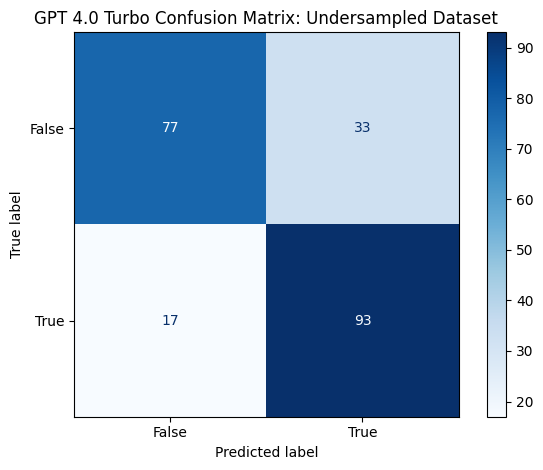

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true, preds)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('GPT 4.0 Turbo Confusion Matrix: Undersampled Dataset')
plt.tight_layout()
plt.show()

### Summarized but with diff prompt

In [ ]:
new_summarized = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/cleaned_banktrack_annotated.csv')

# Use Coral's balanced dataset

#spliting data
#split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42, shuffle=True)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(new_summarized, test_size=0.2, random_state=42) #validation size is 20%, random state is just there for reproducibility

# turn to json dict
#dataset = DatasetDict({"train": split_dataset["train"]})
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'train': Dataset.from_pandas(train_df.reset_index()), 'validation': Dataset.from_pandas(val_df.reset_index())}) #use dataset dict to turn to dataframe to dict
dataset

In [ ]:
import openai
def classify_batch(batch_texts, start_idx=1):
    few_shot_prompt = """A Form 8-K is a public document that publicly traded companies must file with the Securities and Exchange Commission to disclose significant, unscheduled events or corporate changes. These events are considered material, meaning they could impact the company's financial performance or investor decisions. Debt financing is when a company borrows money (or is given the right to borrow money) from a collection of lenders. This is primarily done through bonds, notes, loans, credit facilities. Key words include: Term Loan Agreement, Amended and Restated Credit Agreement, Revolving Credit Agreement, Junior Subordinated Notes, Bond, Debt Settlement Agreement.Classification is 'True' if the item contains details about a debt instrument. If the item just references a debt instrument, this column should still be false. There must be some details outside of the name (such as the start date, the amount, the lenders, etc.). I want you to think like a financial analyst reviewing SEC Form 8-K filings to determine whether they contain information related to commercial debt. Your response should classify each text with a “True” or “False” label. Do not explain.

Examples:
1. "As previously disclosed, between December 14, 2022 and December 16, 2022, IronNet, Inc. This Company  issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the Initial Notes)  to a total of eight lenders, and on December 30, 2022, the Company issued a secured promissory note in the principal amount of $2.0 million (the First C5 Note ) to an entity affiliated with C5 Capital Limited, a beneficial owner of more than 5% of the Company's outstanding common stock. In connection with the issuance of the First C5 Note, the Company and the holders of the Initial Notes agreed to amend and restate the Initial Notes to be substantially in the form to be issued to C5, which form was attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023 (the  Restated Initial Notes). This amendment and restatement occurred on January 11, 2023. The Restated Initial Notes continue to bear interest at a rate of 13.8% per annum from the respective dates of the Initial Notes, and the Restated Initial Notes are payable at scheduled maturity on June 30, 2023.    Upon entering into the First C5 Note, the Company and C5 also agreed to amend and restate the First C5 Note. Subsequently, the parties agreed that the amended and restated First C5 Note and any future notes to be issued in connection with additional bridge financing by C5 would be convertible into shares of the Company's common stock. On January 11, 2023, the Company issued to C5 an amended and restated convertible promissory note in the principal amount of $2.0 million (the Restated C5 Note). On January 12, 2023, the Company issued to C5 a new secured convertible promissory note in the principal amount of $3.0 million (the Second C5 Note). The Restated C5 Note and the Second C5 Note (collectively, the C5 Notes), in the aggregate principal amount of $5.0 million, are in substantially the form of secured convertible promissory note attached to this report as Exhibit 99.1.    The C5 Notes bear interest at a rate of 13.8% per annum from the date of issuance (or in the case of the Restated C5 Note, from the date of the First C5 Note), and all such notes are payable at scheduled maturity on June 30, 2023, subject to acceleration in certain circumstances.    The Company's obligations under the Restated Initial Notes and the C5 Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. C5 and each of the holders of the Restated Initial Notes have executed an Amended and Restated Security Agreement in the form attached as an exhibit to the Current Report on Form  8-K  filed on January 4, 2023.    The C5 Notes provide C5 with the right, at any time on or after the date that is five calendar days prior to maturity, to convert any portion of the principal amount of the C5 Notes, together with any accrued and unpaid interest and any other unpaid amounts, into shares of the Company's common stock, par value $0.0001 per share (the Common Stock ), at a conversion price of $2.00 per share. In the event that any shares of Common Stock are issued upon conversion of the C5 Notes, the Company has agreed to grant specified registration rights to C5.    The foregoing description of the C5 Notes does not purport to be complete and is subject to, and is qualified in its entirety by reference to, the form of C5 Note filed herewith as Exhibit 99.1 and incorporated herein by reference. " → True
2. "Between December 14, 2022 and December 16, 2022, IronNet, Inc. (the Company ) issued and sold secured promissory notes in an aggregate principal amount of $6.9 million (the Notes) to a total of eight lenders. The lenders included GEN Keith B. Alexander (Ret.), the founder, Chief Executive Officer and Chairman of the Board of Directors of the Company. The Notes were also issued to lenders that include VADM John M. McConnell (Ret.), Hon. Michael J. Rogers, Theodore E. Schlein and VADM Jan E. Tighe (Ret.), each of whom is a director of the Company, as well as funds affiliated with Forgepoint Capital (the Forgepoint Funds). Donald R. Dixon, a member of the Company's board of directors, is an affiliate of ForgePoint Capital, and the Forgepoint Funds are also beneficial owners of greater than 5% of the Company's common stock.    Each Note has a scheduled maturity date of one year from the date of issuance, except that the Note issued to one lender that is not, and is not affiliated with, a director of the Company has a scheduled maturity date of six months from the date of issuance. The Notes bear interest at a rate of 13.8% per annum, payable at maturity. The Company may prepay the Notes at any time without premium or penalty, and the Notes do not restrict the incurrence of future indebtedness by the Company.    In the event that the Company fails to timely pay amounts due under the Notes or the Company materially defaults in its performance of any other covenant under the Notes or the Security Agreement (as defined below), which default is not cured within 30 days after written notice thereof, then at the option of the lenders, upon the written consent of lenders representing a majority of the outstanding and unpaid principal under the Notes, all unpaid principal, accrued interest and other amounts owing under the Notes shall be immediately due and payable.    In the event that the Company files any petition or action for relief under any bankruptcy, reorganization, insolvency or moratorium law or any other law for the relief of or relating to debtors, or makes any assignment for the benefit of creditors or takes any corporate action in furtherance thereof, or if an involuntary petition is filed against the Company (unless such petition is dismissed or discharged within 60 days) under any bankruptcy statute, or a custodian, receiver, trustee, assignee for the benefit of creditors is appointed to take possession, custody or control of any property of the Company, then all unpaid principal, accrued interest and other amounts owing under the Notes will accelerate and automatically become immediately due and payable.    The Notes are secured by substantially all of the assets of the Company, excluding the Company's intellectual property. The Company entered into a Security Agreement (the Security Agreements ) with each of the lenders.    The forgoing descriptions of the Notes and the Security Agreements do not purport to be complete and are subject to, and is qualified in its entirety by reference to, the form of Note and form of Security Agreement filed hereto as Exhibits 4.1 and 10.1, respectively, and incorporated herein by reference. " → True
3. "Underwriting Agreement On May 12, 2014, Concho Resources Inc. (the Company ) entered into an underwriting agreement (the Underwriting Agreement ) with Goldman, Sachs & Co., as representative of the several underwriters listed in Schedule I thereto (the Underwriters ), in connection with an underwritten public offering of up to 7,475,000 shares of common stock (the Common Shares ), including the Underwriters option to purchase up to an additional 975,000 shares. The issuance and sale of the Common Shares has been registered under the Securities Act of 1933 (the Securities Act ) pursuant to an automatic shelf Registration Statement on Form S-3 (Registration No. 333-184037) of the Company, filed with and deemed automatically effective by the Securities and Exchange Commission on September 21, 2012. On May 13, 2014, the Underwriters exercised their option to purchase additional shares in full. Closing of the issuance and sale of the Common Shares is expected to occur on May 16, 2014, subject to customary closing conditions. A legal opinion related to the Common Shares is filed herewith as Exhibit 5.1. The Underwriting Agreement contains customary representations, warranties and agreements by the Company and customary conditions to closing, obligations of the parties and termination provisions. Additionally, the Company has agreed to indemnify the Underwriters against certain liabilities, including liabilities under the Securities Act, or to contribute to payments the Underwriters may be required to make because of any of those liabilities. Furthermore, the Company has agreed with the Underwriters not to offer or sell any shares of its common stock (or securities convertible into or exchangeable for common stock), subject to customary objections, for a period of 60 days after the date of the Underwriting Agreement without the prior written consent of Goldman, Sachs & Co. The Underwriters or their affiliates have from time to time provided investment banking, commercial banking and financial advisory services to the Company, for which they have received customary compensation. The Underwriters and their affiliates may provide similar services in the future. Specifically, Bank of America, N.A., an affiliate of Merrill Lynch, Pierce, Fenner & Smith Incorporated, serves as a co-syndication agent and a lender; JPMorgan Chase Bank, N.A., an affiliate of J.P. Morgan Securities LLC, serves as administrative agent and a lender; Barclays Bank PLC, an affiliate of Barclays Capital Inc., serves as a lender; BMO Harris Financing, Inc., an affiliate of BMO Capital Markets Corp., serves as a lender; Citibank, N.A., an affiliate of Citigroup Global Markets Inc., serves as a lender; Capital One, National Association, an affiliate of Capital One Securities, Inc., serves as a lender, KeyBank National Association, an affiliate of KeyBanc Capital Markets Inc., serves as a lender; Royal Bank of Canada, an affiliate of RBC Capital Markets, LLC, serves as a lender; SunTrust Bank, an affiliate of SunTrust Robinson Humphrey, Inc., serves as a lender and Wells Fargo Bank National Association, an affiliate of Wells Fargo Securities, LLC, serves as a co-syndication agent and a lender under the Companys credit facility and will receive a portion of the proceeds from this offering. In addition, from time to time, the Underwriters and their affiliates may effect transactions for their own account or the account of customers, and hold on behalf of themselves or their customers, long or short positions in our debt or equity securities or loans, and may do so in the future. The foregoing description of the Underwriting Agreement is qualified in its entirety by reference to such Underwriting Agreement, a copy of which is filed herewith as Exhibit 1.1 and is incorporated herein by reference" → False
4. "On December 11, 2020, Innoviva, Inc. (" Innoviva ") entered into a strategic partnership with Sarissa Capital Management LP (" Sarissa Capital ") designed to accelerate the execution of its strategy and enhance returns on its capital. The partnership comprises (i) a strategic advisory agreement, pursuant to which and subject to the terms set forth therein Sarissa Capital will assist Innoviva in the development of its acquisition strategy and (ii) an investment by Innoviva into an investment fund managed by Sarissa Capital to enhance returns on its capital, as further described herein. The partnership is part of Innoviva's continued focus on increasing shareholder value by diversifying its primary royalty management business that includes respiratory assets partnered with Glaxo Group Limited and optimizing its capital allocation, both through actively pursuing opportunistic acquisitions of promising companies and assets in the healthcare industry and enhancing the returns on its capital. Innoviva believes that Sarissa Capital's strategic position in the healthcare ecosystem, differentiated investment approach and strategic acumen are highly synergistic with our capital deployment strategy and position us well for value creation. Strategic Advisory Agreement As part of the partnership, Innoviva and Sarissa Capital entered into a Strategic Advisory Agreement (the " Services Agreement "), dated December 11, 2020, pursuant to which Sarissa Capital will provide a variety of strategic services to Innoviva in order to assist Innoviva in the development and execution of its acquisition strategy. Pursuant to the terms of the Services Agreement, and subject to the limitations set forth therein, Sarissa Capital will, among other things: (i) assist Innoviva in the development of an overall acquisition and investment process and strategy; (ii) advise Innoviva on market trends, market dynamics and merger and acquisition activity; (iii) identify potential transaction targets; (iv) assist in due diligence of transaction targets and the negotiation and execution of transactions; (v) advise on the growth and operational plans, performance and integration of target companies once an investment or acquisition is made; and (vi) assist in the identification of director and officer candidates for target companies. The Services Agreement provides for the development of an annual work plan to implement the strategic services, and regular collaboration between Sarissa Capital and Innoviva to discuss the work plan and refine the strategic services. Innoviva believes that the partnership will allow it to utilize the expertise and market reach of Sarissa Capital to optimize Innoviva's proprietary investment program, targeting strategic control investments in the healthcare industry, while also focusing on Innoviva's primary business of managing its valuable royalty portfolio. The Services Agreement includes customary indemnification and exculpation provisions and is terminable by Innoviva at any time. In addition, Sarissa Capital may terminate the Services Agreement at any time in the event that one or more withdrawal requests to the Partnership (as defined below) are made which, in the aggregate, cause the value of the interest of Strategic Partners (as defined below) in the Partnership to be less than 50% of the initial subscription amount, as adjusted for any cumulative profits and losses. Investment of Capital In addition to the Services Agreement, as part of Innoviva's efforts to optimize its cash position and increase yield, on December 11, 2020, Innoviva Strategic Partners LLC, a wholly-owned subsidiary of Innoviva (" Strategic Partners "), entered into a subscription agreement (the " Subscription Agreement ") and an Amended and Restated Limited Partnership Agreement (the " Partnership Agreement " and, together with the Subscription Agreement and the other instruments and agreements referenced therein or contemplated thereby, the " Investment - 2 - Documents ") pursuant to which Strategic Partners became a limited partner of ISP Fund LP (the " Partnership "). The general partner of the Partnership (the " General Partner ") is an affiliate of Sarissa Capital and, pursuant to an investment management agreement, Sarissa Capital will act as the investment adviser to the Partnership. Pursuant to the Investment Documents, Strategic Partners made a $300 million initial contribution into the Partnership on a "most favored nations" basis. The Partnership was formed for the purposes of investing in "long-only" securities in the healthcare, pharmaceutical and biotechnology industries. The Partnership Agreement provides certain limitations on the General Partner and the Partnership. Among other things and subject to the limitations set forth in the Partnership Agreement, without the prior approval of Strategic Partners, the Partnership may not participate in any borrowing, leverage or other credit arrangement, enter into certain transactions with Sarissa Capital or its affiliates or invest greater than 20% of the Net Asset Value (as defined in the Partnership Agreement) of the Partnership in the securities of any single issuer (measured at the time of acquisition), however we expect the Partnership's investments to be concentrated in a few larger positions in order to maximize the synergies between the Partnership Agreement, the Services Agreement and our overall acquisition strategy. As compensation for the advisory services to be provided to the Partnership, the Partnership Agreement provides for Sarissa Capital to receive a customary management fee from the Partnership, payable quarterly in advance, measured based on the Net Asset Value of Strategic Partners' capital account in the Partnership. In addition, as more fully described in the Partnership Agreement, the General Partner is entitled to a customary annual performance allocation based on the Net Profits (as defined in the Partnership Agreement) of the Partnership during the annual measurement period (i.e., the excess during the relevant annual measurement period of (x) operating profits of the Partnership plus the realized and unrealized increase in the value of securities held by the Partnership over (y) operating losses of the Partnership plus the realized and unrealized loss in the value of securities held by the Partnership). The performance allocation is payable annually (or a shorter period solely with respect to capital withdrawn from the Partnership prior to year-end) and is calculated based on valuation determinations made by Sarissa Capital or a third-party administrator for the Partnership selected by Sarissa Capital. The foregoing is the sole compensation receivable by Sarissa Capital for the transactions described herein. The Partnership Agreement includes a lock-up period of thirty-six months after which Strategic Partners is entitled to make withdrawals from the Partnership as of such lock-up expiration date and each anniversary thereafter, subject to a 25% gating provision. If Strategic Partners wishes to withdraw more than 25% of its capital, such request will be carried over to the successive quarter-end dates until settled in full over a maximum of four quarter-end dates with respect to withdrawal of the full capital account balance. Payments to Strategic Partners in respect of any withdrawal are to be made within 30 days following the relevant withdrawal effective date. In addition, the Partnership Agreement provides for withdrawal rights at any time upon the occurrence of Cause (as defined in the Partnership Agreement) or in the event of a Key Man Event (as defined in the Partnership Agreement) tied to Dr. Alexander Denner ceasing to be the Chief Investment Officer of Sarissa Capital or otherwise ceasing to oversee the investment activity of the Partnership. Following a withdrawal due to Cause or a Key Man Event, the Partnership is required to distribute withdrawal proceeds as promptly as reasonably practicable following the relevant withdrawal date and without the application of the 25% gate or the lock-up. The Partnership Agreement also provides that Strategic Partners may elect, from time to time, to receive annual distributions of Net Profits (as defined in the Partnership Agreement) net of accrued and reserved expenses and fees of the Partnership. The Partnership Agreement also requires the Partnership to make distributions to Strategic Partners as necessary to allow Innoviva to maintain compliance with the Investment Company Act of 1940 and the rules and regulations promulgated thereunder. - 3 - The Partnership Agreement includes co-investment rights pursuant to which Strategic Partners is entitled to invest ratably in investment opportunities presented to the Partnership and other funds and accounts managed by Sarissa Capital, and capacity rights pursuant to which Strategic Partners is entitled to make additional investments into the Partnership on the same preferential terms. The Partnership Agreement also includes a customary "most favored nations" provision, pursuant to which and subject to certain limitations and conditions, Strategic Partners is entitled to receive the benefit of any more favorable terms or conditions (and any related negative terms or obligations) provided to investors in any other fund or account managed by Sarissa Capital or its affiliates pursuing substantially the same investment strategy. In addition to the terms described above, the Investment Documents include other customary terms and conditions including representations and warranties, indemnities, exculpation, information rights and reporting obligations and allocation of third party expenses. The execution of the Services Agreement and the Investment Documents was approved by a special committee of independent directors of the Innoviva Board represented by independent legal, financial and other advisors. Mark DiPaolo, Esq. and Odysseas D. Kostas, M.D., two of our directors, are partners of Sarissa Capital. Accordingly, these directors have recused themselves to date from any decisions relating to our investment in the Partnership or the Services Agreement. The foregoing is a summary description of certain terms of the Services Agreement and the Partnership Agreement and does not purport to be complete, and is qualified in its entirety by reference to the full text of the Services Agreement, which is attached hereto as Exhibit 10.1, and the Partnership Agreement, which is attached hereto as Exhibit 10.2, each of which is incorporated herein by reference.” → False

Now classify the following:
   """

# building a numbered list of sentences to append to prompt so model can process a batch of inputs at once
# with clear numbering and formatting for each input example
    numbered_batch = ""
    for i, sentence in enumerate(batch_texts, start=start_idx):
        numbered_batch += f"{i}. \"{sentence}\" →\n"

    final_prompt = few_shot_prompt + numbered_batch

    response = client.chat.completions.create( # maybe use different function rather than chat completion
        model="gpt-4-turbo", # wayyy faster than gpt 4; went from 6-7 minutes (only a third complete) to 1 minute (fully complete)
        messages=[{"role": "user", "content": final_prompt}],
        temperature=0
    )

    return response.choices[0].message.content

results = []
batch_size = 5 # Process 5 rows at a time

In [ ]:
# converting the text data into a list, looping through it in batches, classifying each batch,
# printing the output, and collecting all classification results in one list
texts = new_summarized['text'].astype(str).tolist()

results = [] # Initialize the results list before the loop

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    output = classify_batch(batch, start_idx=i+1)
    #print(f"Batch {i//batch_size + 1} output:")
    print(output)
    # Extract just the True/False from each line of the output
    batch_results = [r.split('. ')[1] for r in output.strip().split('\n')]
    results.extend(batch_results)

print(f"Total results collected: {len(results)}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_summarized['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

In [ ]:
from sklearn.metrics import f1_score,classification_report, accuracy_score, precision_score, recall_score

# Convert predictions (from model output strings) to booleans
preds = [r.strip().lower() == 'true' for r in results]

# Get true labels and convert to booleans if needed
true = [str(label).strip().lower() == 'true' for label in new_summarized['contains_debt_instrument_information']]

# Compute classification metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds)
recall = recall_score(true, preds)
f1 = f1_score(true, preds)



f1 = f1_score(true, preds)
print(f"F1 Score: {f1:.3f}")

# (Optional) See full breakdown: precision, recall, etc.
print("\nClassification Report:")
print(classification_report(true, preds))